<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/CTC_train_eval_Colab_Result_deeper_gru_failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [0]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [0]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)
        
        self.gru_2 = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)
        
        self.gru_3 = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        
        output_tensor, _ = self.gru_2(output_tensor)
        
        output_tensor, _ = self.gru_3(output_tensor)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, H, batch_first=True)
        
        self.gru_2 = nn.GRU(H, H, batch_first=True)
        
        self.gru_3 = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor,_ = self.gru(input_tensor)
        
        output_tensor, _ = self.gru_2(output_tensor)
        
        output_tensor, _ = self.gru_3(output_tensor)

        output_tensor = self.fc(output_tensor)
        
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.001)

        self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
#         print(pred_tensor)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
                
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [15]:
print(len(mel_path_list))

print(len(ground_truth_list))

split_index = int(0.8 * len(mel_path_list))

print(split_index)

mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_test = mel_path_list[split_index:]
ground_truth_list_test = ground_truth_list[split_index:]

print(len(mel_path_list_test))

12833
12833
10266
10266
2567


In [17]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_test = Batched_Preloader(mel_path_list_test, ground_truth_list_test, 128)
preloader_test.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 128)
preloader_train.initialize_preloader()

In [0]:
def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [19]:
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_deep.npy').tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_deep.npy').tolist()
except:
    print("Loading Failed")

Loading Failed


Loading Error
09-02 10:43:05
Mean Train Loss: 0.1251039753370172
Mean Evaluation Loss: 0.1415867396732996
-------------------------------------------------------------------------------------------------------
09-02 10:45:18
Mean Train Loss: 0.09776498271994528
Mean Evaluation Loss: 0.08504167856564143
-------------------------------------------------------------------------------------------------------
09-02 10:47:30
Mean Train Loss: 0.08434306426381058
Mean Evaluation Loss: 0.0894595901981426
-------------------------------------------------------------------------------------------------------
09-02 10:49:42
Mean Train Loss: 0.08249170571524325
Mean Evaluation Loss: 0.09960691028916291
-------------------------------------------------------------------------------------------------------
09-02 10:51:54
Mean Train Loss: 0.08212625115143866
Mean Evaluation Loss: 0.08410922958393238
-------------------------------------------------------------------------------------------------------

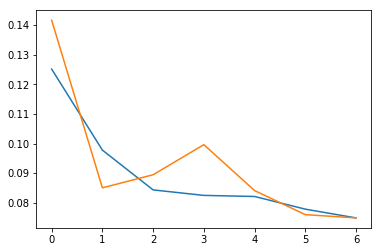

아-----------------------------------------------------------------------------------------------------------------------ᄋᄋᄋᄃ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아ᄋ다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


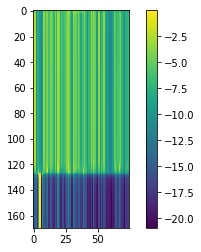

아--------------------------------------------------------------------------------------------------ᄋᄋᄋᄋ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아ᄋ다.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


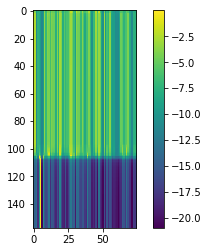

-------------------------------------------------------------------------------------------------------
09-02 10:58:31
Mean Train Loss: 0.07442402638329088
Mean Evaluation Loss: 0.07459657513790706
-------------------------------------------------------------------------------------------------------
09-02 11:00:42
Mean Train Loss: 0.07392857933315446
Mean Evaluation Loss: 0.07339798998129192
-------------------------------------------------------------------------------------------------------
09-02 11:02:53
Mean Train Loss: 0.07361031615177342
Mean Evaluation Loss: 0.07396609954740757
-------------------------------------------------------------------------------------------------------
09-02 11:05:05
Mean Train Loss: 0.07382153496084637
Mean Evaluation Loss: 0.0742593789715231
-------------------------------------------------------------------------------------------------------
09-02 11:07:17
Mean Train Loss: 0.07389430327074253
Mean Evaluation Loss: 0.07586160553934172
-----------

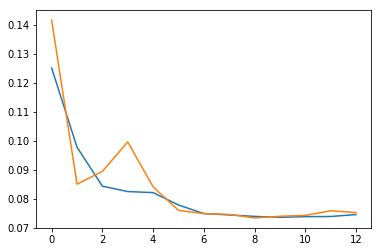

아-----------------------------------------------------------------------------------------------------------------------------------------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아다.<eos>
우리는 금요일 오후에 떠나 일요일 저녁에 돌아올 수 있을 거라 생각했어요.<eos>--------------------


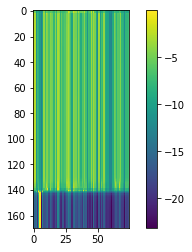

아--------------------------------------------------------------------------------------------------------------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아다.<eos>
그 여성 작가는 여성의 사회적 지위를 높이는 데 크게 기여해 왔다.<eos>-----------------


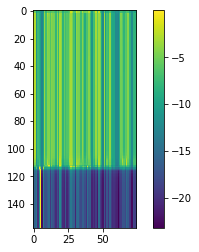

-------------------------------------------------------------------------------------------------------
09-02 11:11:43
Mean Train Loss: 0.07430324397935181
Mean Evaluation Loss: 0.07476981044491945
-------------------------------------------------------------------------------------------------------
09-02 11:13:56
Mean Train Loss: 0.07403487588885323
Mean Evaluation Loss: 0.07382754925328358
-------------------------------------------------------------------------------------------------------
09-02 11:16:08
Mean Train Loss: 0.07353229356977084
Mean Evaluation Loss: 0.07403014913478012
-------------------------------------------------------------------------------------------------------
09-02 11:18:20
Mean Train Loss: 0.07370210023033912
Mean Evaluation Loss: 0.07369221752921884
-------------------------------------------------------------------------------------------------------
09-02 11:20:33
Mean Train Loss: 0.07416994792139346
Mean Evaluation Loss: 0.07549177232112003
----------

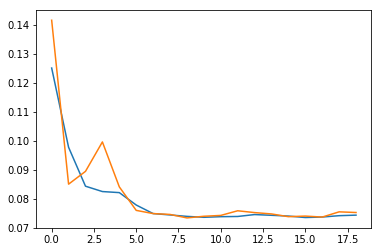

아----------------------------------------------------------------------------------------------------------------------------------------ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
았다.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


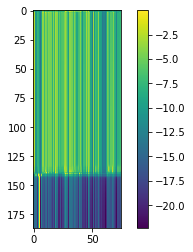

아-----------------------------------------------------------------------------------------------------------------------ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
았다.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


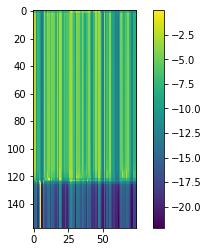

-------------------------------------------------------------------------------------------------------
09-02 11:24:59
Mean Train Loss: 0.07408284202780392
Mean Evaluation Loss: 0.07471118146305354
-------------------------------------------------------------------------------------------------------
09-02 11:27:11
Mean Train Loss: 0.07406281997378067
Mean Evaluation Loss: 0.07420884499951075
-------------------------------------------------------------------------------------------------------
09-02 11:29:23
Mean Train Loss: 0.073982520745147
Mean Evaluation Loss: 0.07318253781175842
-------------------------------------------------------------------------------------------------------
09-02 11:31:36
Mean Train Loss: 0.07322032396053457
Mean Evaluation Loss: 0.07467894569054714
-------------------------------------------------------------------------------------------------------
09-02 11:33:48
Mean Train Loss: 0.07417118512786276
Mean Evaluation Loss: 0.07541397271690083
------------

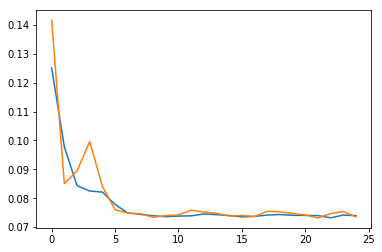

아ᄂ-------------------------------------------------------------------------------------------------------------------------------ᄋᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아ᄂᄋᆻ다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


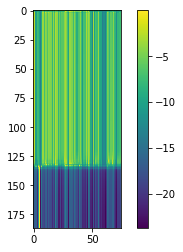

아ᄂ-------------------------------------------------------------------------------------------------ᄋᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아ᄂᄋᆻ다.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


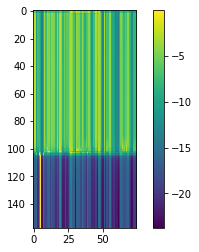

-------------------------------------------------------------------------------------------------------
09-02 11:38:13
Mean Train Loss: 0.07326622744605785
Mean Evaluation Loss: 0.07363637814897578
-------------------------------------------------------------------------------------------------------
09-02 11:40:24
Mean Train Loss: 0.07322274971046076
Mean Evaluation Loss: 0.07499444822347276
-------------------------------------------------------------------------------------------------------
09-02 11:42:37
Mean Train Loss: 0.07452153691778504
Mean Evaluation Loss: 0.07492542351197276
-------------------------------------------------------------------------------------------------------
09-02 11:44:50
Mean Train Loss: 0.07365066587603322
Mean Evaluation Loss: 0.07431110739157003
-------------------------------------------------------------------------------------------------------
09-02 11:47:02
Mean Train Loss: 0.07352763900621448
Mean Evaluation Loss: 0.07306168403008886
----------

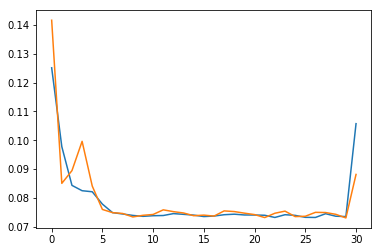

으------------------------------------------------------------------------------------------------------------------------------------------------------------------------
으
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


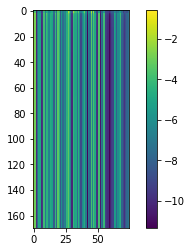

아------------------------------------------------------------------------------------------------------------------------------------------------------------
아
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


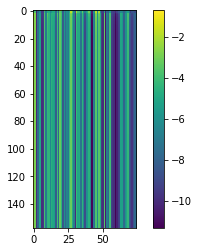

-------------------------------------------------------------------------------------------------------
09-02 11:51:23
Mean Train Loss: 0.08603583426264151
Mean Evaluation Loss: 0.08484884872685945
-------------------------------------------------------------------------------------------------------
09-02 11:53:33
Mean Train Loss: 0.08525151410180193
Mean Evaluation Loss: 0.0908222144842917
-------------------------------------------------------------------------------------------------------
09-02 11:55:42
Mean Train Loss: 0.0872126474205639
Mean Evaluation Loss: 0.08491387878506454
-------------------------------------------------------------------------------------------------------
09-02 11:57:52
Mean Train Loss: 0.08492151817322299
Mean Evaluation Loss: 0.08391875834376725
-------------------------------------------------------------------------------------------------------
09-02 12:00:01
Mean Train Loss: 0.08456720683824841
Mean Evaluation Loss: 0.08582840307178208
------------

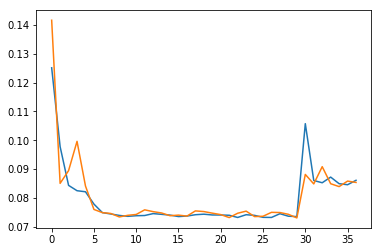

아-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
아
몇몇 비양심적인 공무원들이 자신들의 지위를 이용해 뇌물을 받았음이 드러났다.<eos>----------


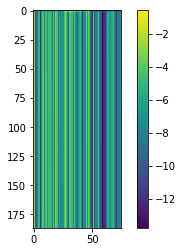

아------------------------------------------------------------------------------------------------------------------------------------------------------------
아
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


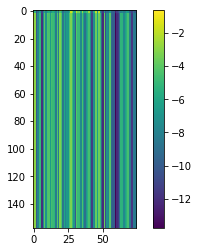

-------------------------------------------------------------------------------------------------------
09-02 12:04:23
Mean Train Loss: 0.08526632264673518
Mean Evaluation Loss: 0.08405482536741658
-------------------------------------------------------------------------------------------------------
09-02 12:06:32
Mean Train Loss: 0.08418429128411706
Mean Evaluation Loss: 0.08419368289059127
-------------------------------------------------------------------------------------------------------
09-02 12:08:42
Mean Train Loss: 0.08467190733415077
Mean Evaluation Loss: 0.08432838626408795
-------------------------------------------------------------------------------------------------------
09-02 12:10:51
Mean Train Loss: 0.08619355682131956
Mean Evaluation Loss: 0.08498276979950324
-------------------------------------------------------------------------------------------------------
09-02 12:13:02
Mean Train Loss: 0.0856582862080764
Mean Evaluation Loss: 0.08543074066527254
-----------

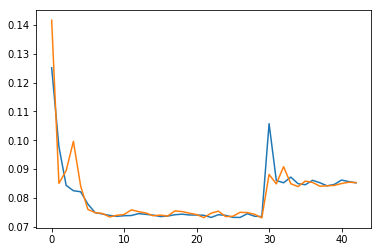

아-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
아
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


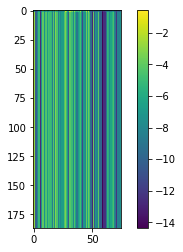

아------------------------------------------------------------------------------------------------------------------------------------------------------------
아
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


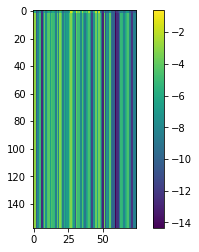

-------------------------------------------------------------------------------------------------------
09-02 12:17:23
Mean Train Loss: 0.08576709077601388
Mean Evaluation Loss: 0.08363070354001459
-------------------------------------------------------------------------------------------------------
09-02 12:19:33
Mean Train Loss: 0.08503154613729161
Mean Evaluation Loss: 0.08593112884538534
-------------------------------------------------------------------------------------------------------
09-02 12:21:43
Mean Train Loss: 0.08603548678200333
Mean Evaluation Loss: 0.08511944929197197
-------------------------------------------------------------------------------------------------------
09-02 12:23:52
Mean Train Loss: 0.0850835580485083
Mean Evaluation Loss: 0.08545077595734615
-------------------------------------------------------------------------------------------------------
09-02 12:26:02
Mean Train Loss: 0.08522396434397335
Mean Evaluation Loss: 0.08394525263230751
-----------

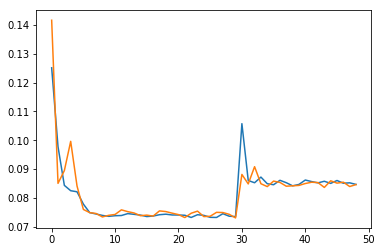

아-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
아
오늘 이렇게 한국어에 관한 초청 강연을 할 수 있게 되어 영광스럽게 생각합니다.<eos>----------


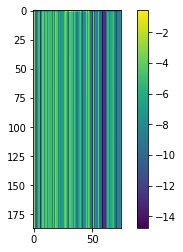

아------------------------------------------------------------------------------------------------------------------------------------------------------------
아
그 여성 작가는 여성의 사회적 지위를 높이는 데 크게 기여해 왔다.<eos>-----------------


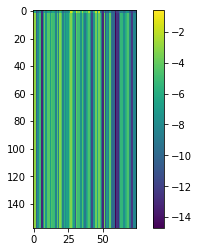

-------------------------------------------------------------------------------------------------------
09-02 12:30:23
Mean Train Loss: 0.085496741081624
Mean Evaluation Loss: 0.0847529852376366
-------------------------------------------------------------------------------------------------------
09-02 12:32:32
Mean Train Loss: 0.08497293571019243
Mean Evaluation Loss: 0.08500269934541677
-------------------------------------------------------------------------------------------------------
09-02 12:34:43
Mean Train Loss: 0.08493050982640246
Mean Evaluation Loss: 0.08595991143143121
-------------------------------------------------------------------------------------------------------
09-02 12:36:54
Mean Train Loss: 0.08538649186697876
Mean Evaluation Loss: 0.0859340910787999
-------------------------------------------------------------------------------------------------------
09-02 12:39:03
Mean Train Loss: 0.08607947659721929
Mean Evaluation Loss: 0.08599970776925178
--------------

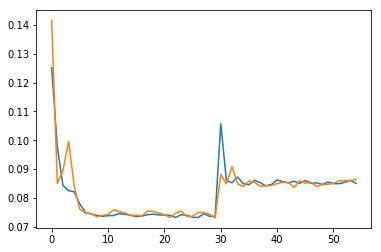

아------------------------------------------------------------------------------------------------------------------------------------------------------------------------
아
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


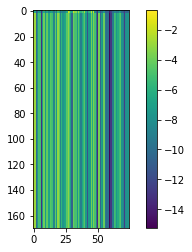

아------------------------------------------------------------------------------------------------------------------------------------------------------------
아
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


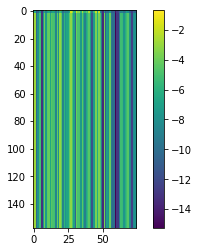

-------------------------------------------------------------------------------------------------------
09-02 12:43:23
Mean Train Loss: 0.08665911341806601
Mean Evaluation Loss: 0.08466837772062165
-------------------------------------------------------------------------------------------------------
09-02 12:45:34
Mean Train Loss: 0.08530244226287141
Mean Evaluation Loss: 0.08436614048939221
-------------------------------------------------------------------------------------------------------
09-02 12:47:44
Mean Train Loss: 0.08501599826365924
Mean Evaluation Loss: 0.08370902768442244
-------------------------------------------------------------------------------------------------------
09-02 12:49:55
Mean Train Loss: 0.08441101781079599
Mean Evaluation Loss: 0.08504134825362357
-------------------------------------------------------------------------------------------------------
09-02 12:52:06
Mean Train Loss: 0.0850340427976669


In [0]:
EPOCH = 3 * 60 * 4
    
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval_deep')
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_test.initialize_batch()
    loss_list_eval = list()
    
    while preloader_test.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_test.get_batch()
        pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval_deep')
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_deep.npy', loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_deep.npy', loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        _, index = pred_tensor[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")